# Graph Neural Networks

![graphNN](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*CWUg-DZBQNONJXuxQdLrFQ.png)

https://distill.pub/2021/gnn-intro/

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.datasets import TUDataset
from torch_geometric.data import DataLoader
from torch_geometric.nn import GCNConv, global_add_pool

# Load a toy molecule dataset

# Biological data sets such as MUTAG, ENZYMES, PROTEINS are graphs that represent small or large molecules, 
# where edges of the graphs are chemical bonds or spatial proximity between different atoms. Graph labels 
# in these cases encode different properties like toxicity.
# source: https://arxiv.org/pdf/1910.12091.pdf
dataset = TUDataset(root='/tmp/PROTEINS', name='PROTEINS')

# Split the dataset into training and testing sets
dataset = dataset.shuffle()
train_dataset = dataset[:int(len(dataset) * 0.7)]
val_dataset = dataset[int(len(dataset) * 0.7):int(len(dataset) * 0.85)]
test_dataset = dataset[int(len(dataset) * 0.85):]

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Instantiate the GNN model
input_dim = dataset.num_features
hidden_dim = 64
output_dim = dataset.num_classes

/Users/nataliakees/miniconda3/envs/python_data_env/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [2]:
dataset.print_summary()

TUDataset (#graphs=1113):
+------------+----------+----------+
|            |   #nodes |   #edges |
|------------+----------+----------|
| mean       |     39.1 |    145.6 |
| std        |     45.8 |    169.3 |
| min        |      4   |     10   |
| quantile25 |     15   |     56   |
| median     |     26   |     98   |
| quantile75 |     45   |    174   |
| max        |    620   |   2098   |
+------------+----------+----------+


In [3]:
# Inspect dataset metadata
print("Number of graphs:", len(dataset))
print("Number of features per node:", dataset.num_features)
print("Number of classes:", dataset.num_classes)

# Access an individual graph from the dataset
graph = dataset[0]  # Accessing the first graph in the dataset

# Inspect the properties of the graph
print("Graph information (first example):")
print("Number of nodes:", graph.num_nodes)
print("Number of edges:", graph.num_edges)
print("Node features shape:", graph.x.shape)
print("Edge indices shape:", graph.edge_index.shape)
print("Graph-level label:", graph.y.item())

# You can convert edge_index to an edge list for better readability
edge_list = graph.edge_index.t().tolist()
print("Edge list:", edge_list)

# You can also convert node features to a numpy array for easier manipulation
node_features = graph.x.numpy()
print("Node features:", node_features)


Number of graphs: 1113
Number of features per node: 3
Number of classes: 2
Graph information (first example):
Number of nodes: 44
Number of edges: 172
Node features shape: torch.Size([44, 3])
Edge indices shape: torch.Size([2, 172])
Graph-level label: 0
Edge list: [[0, 1], [0, 2], [0, 3], [1, 0], [1, 2], [1, 3], [2, 0], [2, 1], [2, 3], [2, 4], [3, 0], [3, 1], [3, 2], [3, 4], [3, 5], [3, 36], [3, 37], [4, 2], [4, 3], [4, 5], [4, 36], [4, 37], [5, 3], [5, 4], [5, 6], [5, 36], [5, 37], [6, 5], [6, 7], [6, 8], [7, 6], [7, 8], [7, 9], [8, 6], [8, 7], [8, 9], [8, 10], [9, 7], [9, 8], [9, 10], [10, 8], [10, 9], [10, 11], [10, 12], [11, 10], [11, 12], [11, 13], [11, 38], [12, 10], [12, 11], [12, 13], [12, 14], [12, 38], [13, 11], [13, 12], [13, 14], [13, 38], [13, 39], [14, 12], [14, 13], [14, 15], [14, 16], [14, 17], [14, 39], [15, 14], [15, 16], [15, 17], [16, 14], [16, 15], [16, 17], [16, 39], [17, 14], [17, 15], [17, 16], [17, 18], [18, 17], [18, 19], [18, 20], [19, 18], [19, 20], [19, 21]

/Users/nataliakees/miniconda3/envs/python_data_env/lib/python3.11/site-packages/networkx/drawing/nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


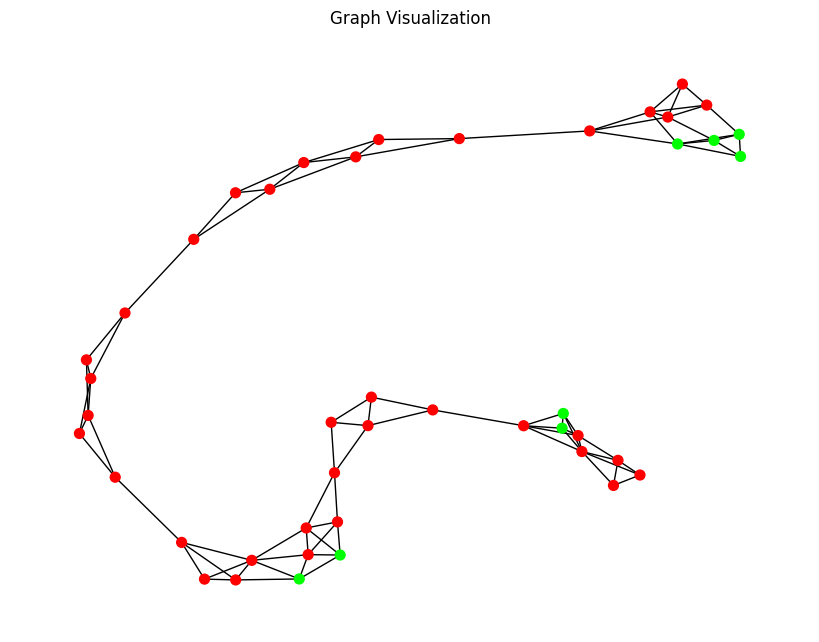

In [4]:
import networkx as nx
import matplotlib.pyplot as plt

# Convert edge_index to edge list
edge_list = graph.edge_index.t().tolist()

# Create a networkx graph
G = nx.Graph()

# Add nodes with their features
for i in range(graph.num_nodes):
    G.add_node(i, features=graph.x[i])

# Add edges
for edge in edge_list:
    src, tgt = edge
    G.add_edge(src, tgt)

# Define node colors based on features (for visualization purposes)
node_colors = [tuple(features.tolist()) for _, features in G.nodes(data='features')]

# Plot the graph
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G)  # Layout algorithm
nx.draw(G, pos, with_labels=False, node_size=50, node_color=node_colors, cmap=plt.cm.jet)
plt.title('Graph Visualization')
plt.show()

In [5]:
import torch
from torch_geometric.utils import to_dense_adj

# Convert edge_index to adjacency matrix
adjacency_matrix = to_dense_adj(graph.edge_index)
adjacency_matrix

# матриця суміжності

tensor([[[0., 1., 1.,  ..., 0., 0., 0.],
         [1., 0., 1.,  ..., 0., 0., 0.],
         [1., 1., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 1., 1.],
         [0., 0., 0.,  ..., 1., 0., 1.],
         [0., 0., 0.,  ..., 1., 1., 0.]]])

In [6]:
from torch_geometric.data import Data

def adjacency_list(data):
    num_nodes = data.num_nodes
    adj_list = [[] for _ in range(num_nodes)]
    
    # Iterate through the edge_index tensor to populate the adjacency list
    for src, dst in data.edge_index.t().tolist():
        adj_list[src].append(dst)
    
    return adj_list

adj_list = adjacency_list(graph)
adj_list
# список суміжності

[[1, 2, 3],
 [0, 2, 3],
 [0, 1, 3, 4],
 [0, 1, 2, 4, 5, 36, 37],
 [2, 3, 5, 36, 37],
 [3, 4, 6, 36, 37],
 [5, 7, 8],
 [6, 8, 9],
 [6, 7, 9, 10],
 [7, 8, 10],
 [8, 9, 11, 12],
 [10, 12, 13, 38],
 [10, 11, 13, 14, 38],
 [11, 12, 14, 38, 39],
 [12, 13, 15, 16, 17, 39],
 [14, 16, 17],
 [14, 15, 17, 39],
 [14, 15, 16, 18],
 [17, 19, 20],
 [18, 20, 21],
 [18, 19, 21, 22],
 [19, 20, 22, 23],
 [20, 21, 23],
 [21, 22, 24],
 [23, 25, 26],
 [24, 26, 27],
 [24, 25, 27, 28],
 [25, 26, 28, 29],
 [26, 27, 29, 30],
 [27, 28, 30],
 [28, 29, 31],
 [30, 32, 33, 40],
 [31, 33, 34, 35, 40],
 [31, 32, 34, 35, 41],
 [32, 33, 35, 43],
 [32, 33, 34],
 [3, 4, 5, 37],
 [3, 4, 5, 36],
 [11, 12, 13, 39],
 [13, 14, 16, 38],
 [31, 32, 41, 42, 43],
 [33, 40, 42, 43],
 [40, 41, 43],
 [34, 40, 41, 42]]

In [7]:
# Access an individual graph from the dataset
graph = dataset[1]  # Accessing the second graph in the dataset

# Inspect the properties of the graph
print("Graph information (second example):")
print("Number of nodes:", graph.num_nodes)
print("Number of edges:", graph.num_edges)
print("Node features shape:", graph.x.shape)
print("Edge indices shape:", graph.edge_index.shape)
print("Graph-level label:", graph.y.item())

# You can convert edge_index to an edge list for better readability
edge_list = graph.edge_index.t().tolist()
print("Edge list:", edge_list)

# You can also convert node features to a numpy array for easier manipulation
node_features = graph.x.numpy()
print("Node features:", node_features)

Graph information (second example):
Number of nodes: 5
Number of edges: 18
Node features shape: torch.Size([5, 3])
Edge indices shape: torch.Size([2, 18])
Graph-level label: 1
Edge list: [[0, 1], [0, 3], [0, 4], [1, 0], [1, 2], [1, 3], [1, 4], [2, 1], [2, 3], [2, 4], [3, 0], [3, 1], [3, 2], [3, 4], [4, 0], [4, 1], [4, 2], [4, 3]]
Node features: [[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


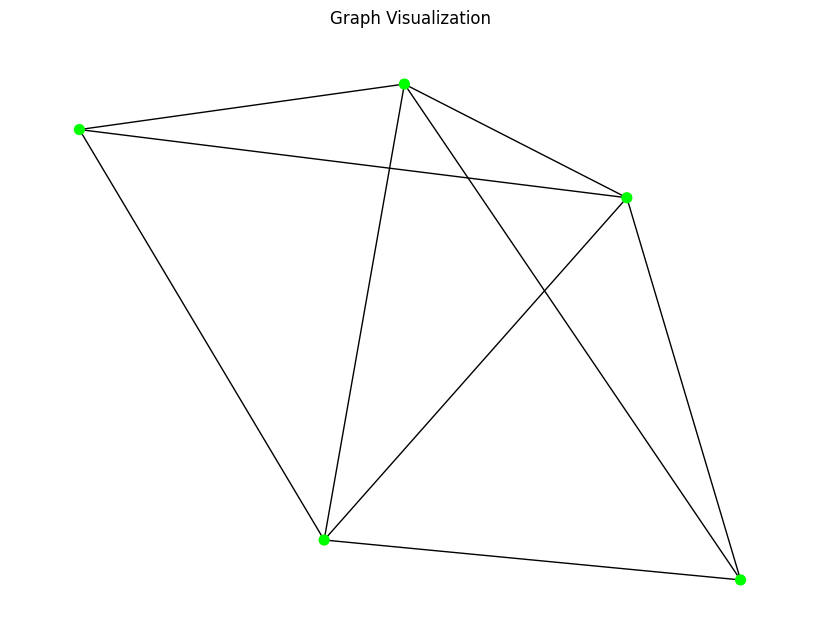

In [8]:
import networkx as nx
import matplotlib.pyplot as plt

# Convert edge_index to edge list
edge_list = graph.edge_index.t().tolist()

# Create a networkx graph
G = nx.Graph()

# Add nodes with their features
for i in range(graph.num_nodes):
    G.add_node(i, features=graph.x[i])

# Add edges
for edge in edge_list:
    src, tgt = edge
    G.add_edge(src, tgt)

# Define node colors based on features (for visualization purposes)
node_colors = [tuple(features.tolist()) for _, features in G.nodes(data='features')]

# Plot the graph
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G)  # Layout algorithm
nx.draw(G, pos, with_labels=False, node_size=50, node_color=node_colors, cmap=plt.cm.jet)
plt.title('Graph Visualization')
plt.show()


## Simplest example: MLP

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Generate a simple graph with random node features
num_nodes = 10
input_dim = 5  # Dimensionality of node features
hidden_dim = 10  # Dimensionality of the hidden layer in the MLP

# Generate random node features
node_features = torch.randn(num_nodes, input_dim)

# Define a simple graph (adjacency matrix)
adjacency_matrix = torch.randint(0, 2, (num_nodes, num_nodes))  # Random binary adjacency matrix
node_features

tensor([[-1.6249, -1.4356,  0.8056, -0.3641,  0.2161],
        [-0.5043, -0.3799,  0.9620, -0.5672, -0.8530],
        [-1.4044, -1.0146, -1.1416, -1.3647, -1.7402],
        [ 0.7498,  0.4652, -0.6787,  0.9995,  0.9415],
        [ 0.9078, -0.2355, -2.4387,  0.4117,  0.5669],
        [ 0.7317,  0.2015,  1.0115, -0.4291, -1.9056],
        [-0.4995,  0.1840,  1.0922, -0.7316, -1.2205],
        [ 0.2336,  1.5441, -1.3911,  0.3148,  0.0678],
        [-0.3614, -2.0884, -0.8305,  0.5937,  0.7649],
        [ 0.9836, -2.9235,  0.8849, -0.3512,  0.3287]])

In [10]:
adjacency_matrix

tensor([[0, 1, 1, 1, 0, 1, 1, 1, 1, 0],
        [1, 0, 1, 1, 1, 0, 1, 1, 1, 0],
        [0, 0, 0, 1, 1, 1, 1, 0, 0, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 1, 1],
        [0, 0, 1, 1, 1, 1, 0, 1, 0, 1],
        [1, 1, 1, 1, 0, 1, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1, 0, 1, 1, 1],
        [0, 0, 0, 0, 1, 0, 1, 0, 0, 0],
        [1, 0, 1, 1, 0, 0, 0, 1, 0, 0],
        [0, 1, 1, 0, 0, 0, 0, 0, 1, 0]])

In [11]:
# Define an MLP model to generate node embeddings
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x

# Instantiate the MLP model
mlp_model = MLP(input_dim, hidden_dim)

# Generate node embeddings using the MLP model
node_embeddings = mlp_model(node_features)

print("Node embeddings shape:", node_embeddings.shape)
print(node_embeddings)

Node embeddings shape: torch.Size([10, 10])
tensor([[4.7416e-02, 8.2577e-01, 0.0000e+00, 7.0256e-02, 1.3640e-01, 6.3665e-01,
         4.1788e-01, 1.0201e-01, 3.4901e-02, 5.5277e-01],
        [0.0000e+00, 7.4674e-01, 0.0000e+00, 7.2468e-02, 1.2608e-01, 4.2536e-01,
         4.7336e-01, 0.0000e+00, 0.0000e+00, 4.6738e-01],
        [0.0000e+00, 2.7155e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.7541e-02,
         0.0000e+00, 0.0000e+00, 1.2217e-01, 3.3176e-01],
        [0.0000e+00, 2.1930e-01, 2.3565e-01, 2.2245e-01, 0.0000e+00, 3.2055e-01,
         2.9297e-01, 0.0000e+00, 0.0000e+00, 3.5934e-01],
        [0.0000e+00, 2.7565e-01, 5.4292e-01, 6.3888e-01, 0.0000e+00, 1.8895e-01,
         1.6289e-01, 0.0000e+00, 0.0000e+00, 3.6395e-01],
        [0.0000e+00, 5.9780e-01, 1.2949e-01, 2.3768e-01, 9.0939e-02, 0.0000e+00,
         2.4271e-01, 0.0000e+00, 2.9764e-02, 5.2224e-01],
        [0.0000e+00, 7.6172e-01, 0.0000e+00, 5.8005e-02, 1.4873e-01, 2.8406e-01,
         5.0815e-01, 0.0000e+00, 0.0000e+

In [12]:
# add information about the nodes

import torch
import torch.nn as nn
import torch.nn.functional as F

# Generate a simple graph with random node features and edge features
num_nodes = 10
input_dim = 5  # Dimensionality of node features
edge_dim = 2   # Dimensionality of edge features
hidden_dim = 10  # Dimensionality of the hidden layer in the MLP

# Generate random node features
# node_features = torch.randn(num_nodes, input_dim)

# Generate random edge features (assuming an undirected graph)
adjacency_matrix = adjacency_matrix.float()  # Random binary adjacency matrix
edge_features = torch.randn(num_nodes, num_nodes, edge_dim) * adjacency_matrix.unsqueeze(-1)  # Edge features for each pair of connected nodes
edge_features

tensor([[[ 0.0000,  0.0000],
         [ 2.9406, -0.4675],
         [ 1.1421, -0.6464],
         [-0.8461, -0.7404],
         [-0.0000, -0.0000],
         [-1.6687, -0.1663],
         [-0.4586, -0.2486],
         [ 0.2209,  0.0616],
         [ 1.3638, -1.4009],
         [-0.0000,  0.0000]],

        [[-0.6371, -0.4404],
         [-0.0000,  0.0000],
         [-1.1087, -1.1237],
         [ 0.2649, -1.0988],
         [-0.7956, -1.5662],
         [ 0.0000, -0.0000],
         [-0.3795, -0.3048],
         [-0.9307, -0.1342],
         [-0.3743, -0.3272],
         [ 0.0000,  0.0000]],

        [[ 0.0000,  0.0000],
         [-0.0000,  0.0000],
         [ 0.0000, -0.0000],
         [ 1.4173,  0.4582],
         [ 0.7277, -1.3075],
         [ 0.1389, -0.2385],
         [-0.3658,  0.0672],
         [ 0.0000, -0.0000],
         [-0.0000, -0.0000],
         [ 0.6641,  2.8453]],

        [[-0.0000,  0.0000],
         [-1.2589,  0.1585],
         [-0.7321, -0.4805],
         [-0.0000,  0.0000],
        

In [13]:
# Define an MLP model to generate node embeddings
class MLP(nn.Module):
    def __init__(self, input_dim, edge_dim, hidden_dim):
        super(MLP, self).__init__()
        self.node_fc = nn.Linear(input_dim, hidden_dim)
        self.edge_fc = nn.Linear(edge_dim, hidden_dim)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, node_features, edge_features, adjacency_matrix):
        # Node embeddings
        node_embed = F.relu(self.node_fc(node_features))
        # print(node_embed.shape)

        # Edge embeddings
        edge_embed = F.relu(self.edge_fc(edge_features))
        # print(edge_embed.shape)
        
        # Gather embeddings from edges to nodes
        agg_edge_embed = torch.matmul(adjacency_matrix, edge_embed)
        # print(agg_edge_embed.shape)
        
        # Aggregate gathered embeddings via sum operation
        agg_edge_embed = torch.sum(agg_edge_embed, dim=1)
        # print(agg_edge_embed.shape)

        # Combine node and aggregated edge embeddings
        combined_embed = node_embed + agg_edge_embed
        # print(combined_embed.shape)
        
        # Pass through MLP layers
        x = F.relu(self.fc1(combined_embed))
        x = F.relu(self.fc2(x))
        return x

# Instantiate the MLP model
mlp_model = MLP(input_dim, edge_dim, hidden_dim)

# Generate node embeddings using the MLP model
node_embeddings = mlp_model(node_features, edge_features, adjacency_matrix)

print("Node embeddings shape:", node_embeddings.shape)
print(node_embeddings)


Node embeddings shape: torch.Size([10, 10])
tensor([[ 0.0000,  0.0000,  0.7989,  0.0000,  0.0000,  3.7456,  0.0000,  7.6262,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.3776,  0.0000,  3.7345,  4.6637,  0.0000, 10.1618,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  1.7063,  3.1732,  0.0000,  7.3034,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.2238,  0.0000,  3.4296,  4.5048,  0.0000,  9.4134,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  1.9932,  3.5121,  0.0000,  7.7755,
          0.0000,  0.0000],
        [ 0.4518,  0.0000,  0.0000,  0.0000,  0.7949,  2.4658,  0.0000,  7.7905,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.3619,  0.0000,  2.6716,  4.2656,  0.0000,  8.9710,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  4.0559,  4.4371,  0.0000,  9.3057,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.4683,  0.0000,  1.4389,  3.2164,  0.0000,  6.4649,
   

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Generate random binary labels for each node
node_labels = torch.randint(0, 2, (num_nodes,))
node_labels_onehot = F.one_hot(node_labels, 2)

# Define an MLP model to generate node embeddings and perform classification
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, edge_dim, hidden_dim):
        super(MLPClassifier, self).__init__()
        self.node_fc = nn.Linear(input_dim, hidden_dim)
        self.edge_fc = nn.Linear(edge_dim, hidden_dim)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.classifier = nn.Linear(hidden_dim, 2)

    def forward(self, node_features, edge_features, adjacency_matrix):
        # Node embeddings
        node_embed = F.relu(self.node_fc(node_features))
        # print(node_embed.shape)

        # Edge embeddings
        edge_embed = F.relu(self.edge_fc(edge_features))
        # print(edge_embed.shape)
        
        # Gather embeddings from edges to nodes
        agg_edge_embed = torch.matmul(adjacency_matrix, edge_embed)
        # print(agg_edge_embed.shape)
        
        # Aggregate gathered embeddings via sum operation
        agg_edge_embed = torch.sum(agg_edge_embed, dim=1)
        # print(agg_edge_embed.shape)

        # Combine node and aggregated edge embeddings
        combined_embed = node_embed + agg_edge_embed
        # print(combined_embed.shape)
        
        # Pass through MLP layers
        x = F.relu(self.fc1(combined_embed))
        x = F.relu(self.fc2(x))
        
        # Classification layer
        logits = self.classifier(x)
        #print(logits)
        return logits

# Instantiate the MLP classifier model
mlp_classifier = MLPClassifier(input_dim, edge_dim, hidden_dim)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_classifier.parameters(), lr=0.01)

# Training loop
num_epochs = 100

for epoch in range(num_epochs):
    # Forward pass
    logits = mlp_classifier(node_features, edge_features, adjacency_matrix)
    print(logits)
    target = node_labels_onehot
    print(target)
    
    # Compute loss
    loss = criterion(logits, target.float())
    
    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Print loss every few epochs
    if epoch % 10 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item()}')


# After training, you can use the trained model to make predictions or perform evaluations.


tensor([[ 0.1213,  0.0387],
        [ 0.3512,  0.0792],
        [ 0.0086,  0.3458],
        [ 0.2115,  0.0700],
        [-0.0060,  0.3073],
        [ 0.0282,  0.7663],
        [ 0.0505,  0.3835],
        [-0.1121,  0.1389],
        [-0.4239, -0.0215],
        [-0.2341,  0.1469]], grad_fn=<AddmmBackward0>)
tensor([[0, 1],
        [1, 0],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [1, 0],
        [0, 1],
        [1, 0]])
Epoch [0/100], Loss: 0.6327016949653625
tensor([[-0.1709,  0.1820],
        [ 0.1103,  0.3224],
        [-0.5099,  0.5149],
        [-0.0225,  0.2351],
        [-0.4898,  0.4568],
        [-0.4886,  0.8804],
        [-0.3946,  0.5116],
        [-0.3114,  0.3343],
        [-0.7796,  0.1205],
        [-0.6475,  0.3171]], grad_fn=<AddmmBackward0>)
tensor([[0, 1],
        [1, 0],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [1, 0],
        [0, 1],
        [1, 0]])
tensor([[-0.3599,  0.228

In [15]:
# Assuming mlp_classifier is already trained

# Generate new node features and edge features for prediction
new_node_features = torch.randn(num_nodes, input_dim)
new_edge_features = torch.randn(num_nodes, num_nodes, edge_dim) * adjacency_matrix.unsqueeze(-1)

# Forward pass to obtain predictions
with torch.no_grad():
    logits = mlp_classifier(new_node_features, new_edge_features, adjacency_matrix)
print(logits)

tensor([[ -6.3742,   8.8644],
        [ -9.1575,  13.4507],
        [ -7.3024,  10.5231],
        [ -8.5638,  12.2870],
        [ -4.6568,   7.7891],
        [-16.7799,  24.1100],
        [-10.0024,  14.5850],
        [ -5.0625,   6.6761],
        [  5.9062,  -6.5884],
        [  4.7230,  -4.0074]])


In [16]:
probabilities = F.softmax(logits)
probabilities

/var/folders/yn/89lh00053q9czjvfg4fqc0wc0000gn/T/ipykernel_4612/3997794472.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = F.softmax(logits)


tensor([[2.4097e-07, 1.0000e+00],
        [1.5184e-10, 1.0000e+00],
        [1.8133e-08, 1.0000e+00],
        [8.8022e-10, 1.0000e+00],
        [3.9338e-06, 1.0000e+00],
        [1.7447e-18, 1.0000e+00],
        [2.0981e-11, 1.0000e+00],
        [7.9793e-06, 9.9999e-01],
        [1.0000e+00, 3.7468e-06],
        [9.9984e-01, 1.6157e-04]])

In [17]:
# Get predicted class indices (argmax of probabilities)
predicted_classes = torch.argmax(probabilities, dim=-1)

# Print predicted class for each node
print("Predicted classes:")
for i, pred_class in enumerate(predicted_classes):
    print(f"Node {i}: Class {pred_class.item()}")


Predicted classes:
Node 0: Class 1
Node 1: Class 1
Node 2: Class 1
Node 3: Class 1
Node 4: Class 1
Node 5: Class 1
Node 6: Class 1
Node 7: Class 1
Node 8: Class 0
Node 9: Class 0


## Graph Convolutional Network vs. Graph Attention Network
https://www.datacamp.com/tutorial/comprehensive-introduction-graph-neural-networks-gnns-tutorial

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.datasets import TUDataset
from torch_geometric.data import DataLoader
from torch_geometric.nn import GCNConv, global_add_pool

# Define a simple Graph Neural Network model

# Instantiate the GNN model
input_dim = dataset.num_features
hidden_dim = 64
output_dim = dataset.num_classes

class GCNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCNModel, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = global_add_pool(x, batch)  # Aggregate graph-level representation
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
model = GCNModel(input_dim, hidden_dim, output_dim)

# Define loss function and optimizer
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.001)  # Adjust weight_decay as needed

# Training loop
def train():
    model.train()
    for data in train_loader:
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()

# Evaluation function
def evaluate(loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            out = model(data)
            pred = out.argmax(dim=1)
            correct += pred.eq(data.y).sum().item()
            total += len(data.y)
    return correct / total

# Train the model
for epoch in range(100):  # Adjust the number of epochs as needed
    train()
    train_acc = evaluate(train_loader)
    val_acc = evaluate(val_loader)
    print(f'Epoch: {epoch+1}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')


Epoch: 1, Train Acc: 0.6791, Val Acc: 0.6527
Epoch: 2, Train Acc: 0.7099, Val Acc: 0.7066
Epoch: 3, Train Acc: 0.7009, Val Acc: 0.7485
Epoch: 4, Train Acc: 0.7317, Val Acc: 0.7605
Epoch: 5, Train Acc: 0.7317, Val Acc: 0.7964
Epoch: 6, Train Acc: 0.7163, Val Acc: 0.7844
Epoch: 7, Train Acc: 0.7330, Val Acc: 0.8024
Epoch: 8, Train Acc: 0.7356, Val Acc: 0.7964
Epoch: 9, Train Acc: 0.7227, Val Acc: 0.7545
Epoch: 10, Train Acc: 0.7330, Val Acc: 0.8084
Epoch: 11, Train Acc: 0.7445, Val Acc: 0.8204
Epoch: 12, Train Acc: 0.7407, Val Acc: 0.7964
Epoch: 13, Train Acc: 0.7214, Val Acc: 0.7784
Epoch: 14, Train Acc: 0.7471, Val Acc: 0.8204
Epoch: 15, Train Acc: 0.7381, Val Acc: 0.8024
Epoch: 16, Train Acc: 0.7407, Val Acc: 0.8084
Epoch: 17, Train Acc: 0.7356, Val Acc: 0.7844
Epoch: 18, Train Acc: 0.7086, Val Acc: 0.7665
Epoch: 19, Train Acc: 0.7407, Val Acc: 0.8024
Epoch: 20, Train Acc: 0.7356, Val Acc: 0.8144
Epoch: 21, Train Acc: 0.7317, Val Acc: 0.7784
Epoch: 22, Train Acc: 0.7343, Val Acc: 0.78

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.datasets import TUDataset
from torch_geometric.data import DataLoader
from torch_geometric.nn import GCNConv, global_add_pool

# Define a simple Graph Neural Network model
class GCNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.5):
        super(GCNModel, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        x = self.dropout(x)
        x = F.relu(self.conv2(x, edge_index))
        x = self.dropout(x)
        x = global_add_pool(x, batch)  # Aggregate graph-level representation
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

# Instantiate the GNN model
model = GCNModel(input_dim, hidden_dim, output_dim)

# Define loss function and optimizer with weight decay
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.001)  # Adjust weight_decay as needed

# Training loop with early stopping
best_val_acc = 0
patience = 5
counter = 0
for epoch in range(100):  # Adjust the number of epochs as needed
    # Train
    model.train()
    for data in train_loader:
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()

    # Evaluate
    model.eval()
    with torch.no_grad():
        train_acc = evaluate(train_loader)
        val_acc = evaluate(val_loader)
        print(f'Epoch: {epoch+1}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')

        # Check for early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping.")
                break


Epoch: 1, Train Acc: 0.5841, Val Acc: 0.6048
Epoch: 2, Train Acc: 0.6650, Val Acc: 0.6707
Epoch: 3, Train Acc: 0.7291, Val Acc: 0.7844
Epoch: 4, Train Acc: 0.7279, Val Acc: 0.7665
Epoch: 5, Train Acc: 0.7368, Val Acc: 0.8024
Epoch: 6, Train Acc: 0.7227, Val Acc: 0.7485
Epoch: 7, Train Acc: 0.7279, Val Acc: 0.7784
Epoch: 8, Train Acc: 0.7368, Val Acc: 0.8204
Epoch: 9, Train Acc: 0.7189, Val Acc: 0.7545
Epoch: 10, Train Acc: 0.7356, Val Acc: 0.8024
Epoch: 11, Train Acc: 0.7420, Val Acc: 0.7844
Epoch: 12, Train Acc: 0.7368, Val Acc: 0.7784
Epoch: 13, Train Acc: 0.7433, Val Acc: 0.8204
Early stopping.


## Graph Attention Network
https://towardsdatascience.com/graph-attention-networks-in-python-975736ac5c0c

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.datasets import TUDataset
from torch_geometric.data import DataLoader
from torch_geometric.nn import GATConv, global_mean_pool

from sklearn.model_selection import ParameterGrid
import numpy as np

# Define a Graph Attention Network (GAT) model
class GATModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_heads, dropout=0.5):
        super(GATModel, self).__init__()
        self.conv1 = GATConv(input_dim, hidden_dim, heads=num_heads, dropout=dropout)
        self.conv2 = GATConv(hidden_dim * num_heads, output_dim, heads=num_heads, dropout=dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = global_mean_pool(x, batch)
        return F.log_softmax(x, dim=1)

# Define hyperparameters to tune
param_grid = {
    'model_type': ['GAT', 'GCN'],  # Model types to try
    'hidden_size': [32, 64, 128],   # Hidden sizes to try
    'batch_size': [32, 64, 128],     # Batch sizes to try
    'learning_rate': [0.001, 0.01, 0.1],  # Learning rates to try
    'weight_decay': [0.0001, 0.001, 0.01]  # Weight decay values to try
}

best_accuracy = 0
best_params = {}

for params in ParameterGrid(param_grid):
    # Instantiate the GNN model
    model_type = params['model_type']
    if model_type == 'GAT':
        model = GATModel(input_dim, params['hidden_size'], output_dim, 4)
    elif model_type == 'GCN':
        model = GCNModel(input_dim, params['hidden_size'], output_dim)
    else:
        raise ValueError("Invalid model type")

    # Define data loaders with current batch size
    train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=params['batch_size'], shuffle=False)

    # Define loss function and optimizer with current learning rate and weight decay
    criterion = nn.NLLLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'], weight_decay=params['weight_decay'])

    # Training loop
    for epoch in range(10):  # Adjust the number of epochs as needed
        train()
    
    # Evaluate on validation set
    val_acc = evaluate(val_loader)
    print(f'Params: {params}, Val Acc: {val_acc:.4f}')

    # Keep track of the best parameters
    if val_acc > best_accuracy:
        best_accuracy = val_acc
        best_params = params

print("Best parameters:", best_params)
print("Best test accuracy:", best_accuracy)


/Users/nataliakees/miniconda3/envs/python_data_env/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Params: {'batch_size': 32, 'hidden_size': 32, 'learning_rate': 0.001, 'model_type': 'GAT', 'weight_decay': 0.0001}, Val Acc: 0.6168
Params: {'batch_size': 32, 'hidden_size': 32, 'learning_rate': 0.001, 'model_type': 'GAT', 'weight_decay': 0.001}, Val Acc: 0.6168
Params: {'batch_size': 32, 'hidden_size': 32, 'learning_rate': 0.001, 'model_type': 'GAT', 'weight_decay': 0.01}, Val Acc: 0.5928
Params: {'batch_size': 32, 'hidden_size': 32, 'learning_rate': 0.001, 'model_type': 'GCN', 'weight_decay': 0.0001}, Val Acc: 0.6946
Params: {'batch_size': 32, 'hidden_size': 32, 'learning_rate': 0.001, 'model_type': 'GCN', 'weight_decay': 0.001}, Val Acc: 0.6946
Params: {'batch_size': 32, 'hidden_size': 32, 'learning_rate': 0.001, 'model_type': 'GCN', 'weight_decay': 0.01}, Val Acc: 0.7365
Params: {'batch_size': 32, 'hidden_size': 32, 'learning_rate': 0.01, 'model_type': 'GAT', 'weight_decay': 0.0001}, Val Acc: 0.6407
Params: {'batch_size': 32, 'hidden_size': 32, 'learning_rate': 0.01, 'model_type': 